# Load Dataset from ~/data

>  Import libraries and set up source directories


In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from random import randint
from skimage.transform import resize
from skimage import io, img_as_float
import seaborn as sns
import concurrent.futures
import pickle

In [2]:
root = "../data"
labels = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
datapath = []
for label in labels:
    datapath.append(os.path.join(root, label))
datapath

['../data/Uninfected', '../data/Parasitized']

We have 2 classes of images: Uninfected and Parasitized. We will use the following labels for them:
- 0 for Uninfected
- 1 for Parasitized


> Utility Section

In [3]:
# Funzione di utility per convertire immagini in vettori
def img2vec(name: str, size: int) -> np.ndarray:
    """Convert images to vector of size (size, size, 3)

    Args:
        name (str): Name of the image as full path
        size (int): Desired size of the image

    Returns:
        np.ndarray: Vector of size (size, size, 3) of numpy.ndarray
    """
    # open image
    img = img_as_float(io.imread(name))
    # convert image to numpy array and resize it
    return resize(img, (size, size, 3), anti_aliasing=True)

def img2vec_unpacked(arg_list):
    path, size = arg_list[0], arg_list[1]
    return img2vec(path, size)

# Funzione di utility per convertire un vettore in immagine
def vec2img(img_vect: list) -> Image:
    """convert image vector to image"""
    img = Image.fromarray((img_vect * 255.999).astype(np.uint8))
    return img


# Funzione di utility per convertire tutte le immagini in una matrice
def img2matrix(folder: str, size: int) -> np.ndarray:
    """Loop through all images in a folder and convert them into a numpy ndarray.
    Then append every vector to make a matrix of arrays."""
    files = os.listdir(folder)
    counts = len(files)
    img_vect = np.zeros((counts, size, size, 3), dtype=np.float64)
    for i, _ in zip(range(counts), files):
        # convert image to vector
        npArray = img2vec(os.path.join(folder, _), size)
        # append image vector to the empty vector
        img_vect[i, ...] = npArray
    return img_vect


def flat(matrix_list: list) -> list:
    """flatten a list of a matrix n x m x 3 to a list of n x m x 3"""
    shape = np.shape(matrix_list)
    flatted_list = np.asarray(
        [np.reshape(entry, (shape[1] * shape[2] * shape[3])) for entry in matrix_list]
    )
    return flatted_list


> Create data structures that will hold the images and their labels

When we load the images, we will use utility functions to resize them to a common size of 32x32 pixels in order to reduce the size of the dataset. When flattening the images, we will have 32x32x3 = 3072 features.

**Note:** This process is also useful to reduce computation time when training the model.

In [4]:
# convert images to numpy matrices of size (32, 32, 3)
resize_to = 32
"""Commented to speed up the process"""
# We use concurrent.futures to speed up the process, since it is a CPU-bound task
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    uninf_path = [os.path.join(datapath[0], _) for _ in os.listdir(datapath[0])]
#    para_path = [os.path.join(datapath[1], _) for _ in os.listdir(datapath[1])]
#    uninf_args = [(path, resize_to) for path in uninf_path]
#    para_args = [(path, resize_to) for path in para_path]
#    uninf_imgs = executor.map(img2vec_unpacked, uninf_args)
#    para_imgs = executor.map(img2vec_unpacked, para_args)
## convert the map object to numpy array
#uninf_imgs = np.asarray(list(uninf_imgs))
#para_imgs = np.asarray(list(para_imgs))
#np.save(os.path.join(root, "uninf_imgs"), uninf_imgs)
#np.save(os.path.join(root, "para_imgs"), para_imgs)
"""load the numpy arrays from the disk"""
uninf_imgs = np.load(os.path.join(root, "uninf_imgs.npy"))
para_imgs = np.load(os.path.join(root, "para_imgs.npy"))

In [5]:
# create matrix of features from the numpy vectors
X = np.concatenate((uninf_imgs, para_imgs), axis=0)
# create matrix of labels from the numpy vectors length
y = np.asarray([0] * len(uninf_imgs) + [1] * len(para_imgs))
# prepare the vectors for the dataframe
X_flat = flat(X)
y_vert = y.reshape(-1, 1)
# pandas dataframe
df = pd.DataFrame(data=X_flat, columns=range(np.shape(X_flat)[1]))
df_labels = pd.DataFrame(data=y_vert, columns=["labels"])
df = df.merge(df_labels, left_index=True, right_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Make a grayscale version of the images by averaging the RGB values. This will reduce the number of features to 32x32 = 1024.

In [6]:
# Convert images from RGB to grayscale
from skimage.color import rgb2gray
X_bw = np.asarray([rgb2gray(img) for img in X])
X_bw_flat =X_bw.reshape(X_bw.shape[0], -1)
df_bw = pd.DataFrame(data=X_bw_flat, columns=range(np.shape(X_bw_flat)[1]))
df_bw = df_bw.merge(df_labels, left_index=True, right_index=True)
df_bw.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,8.019813e-07,0.000018,0.002227,...,0.034840,4.419231e-04,2.926853e-07,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000003,2.890906e-09,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.009761,2.035121e-04,9.158344e-05,0.000001,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,3.001824e-09,0.000015,1.952459e-04,0.000275,0.029278,...,0.000046,2.692717e-08,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0


Simple check on the distribution of the labels in the training and test sets. This will lead to see that our dataset is balanced.

Is the dataset balanced?  Yes


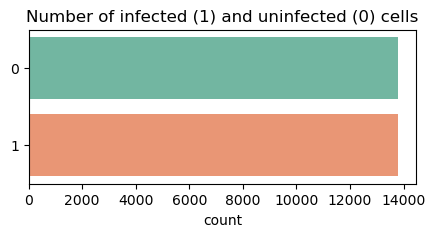

In [7]:
# Count the number of uninfected and infected cells
plt.figure(figsize=(5, 2), dpi=100)
plt.title("Number of infected (1) and uninfected (0) cells")
sns.countplot(y=y, palette="Set2")
label_counts = df['labels'].value_counts()
print("Is the dataset balanced? ", "Yes" if label_counts[0] == label_counts[1] else "No")

>Display sample images

We want to see some images to get a feel for the data and to make sure that the data is loaded correctly. We also want to see if there is something detectable by simply looking at the images before we start training a model.

*Using images as dataset means that we have one variable per pixel, and each image is a point in a very high-dimensional space. Single variable distributions and pairwise correlations are completely meaningless and unmanageable.*

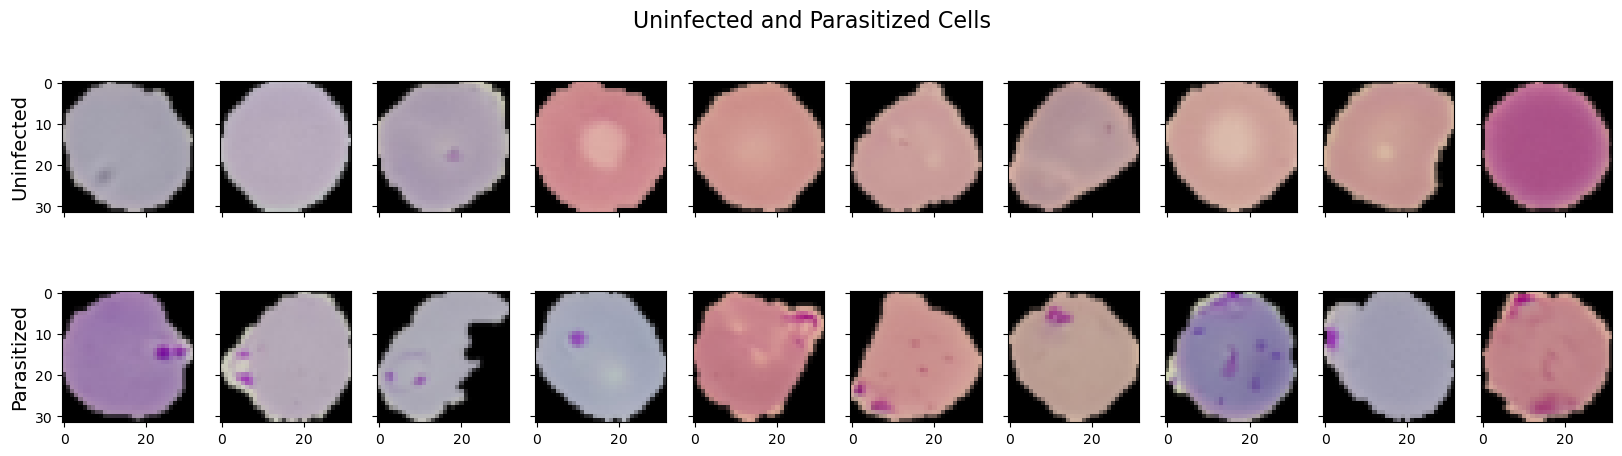

In [8]:
# select 10 random integers - we will use them to select images along this initial process
uninf_index = [randint(0, len(os.listdir(datapath[0]))) for _ in range(10)]
para_index = [randint(0, len(os.listdir(datapath[1]))) for _ in range(10)]
# plot the images
fig, ax = plt.subplots(2, 10, figsize=(20, 5), sharey=True, sharex=True)
fig.suptitle("Uninfected and Parasitized Cells", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs[uninf_index[i]])
    ax[1, i].imshow(para_imgs[para_index[i]])
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()

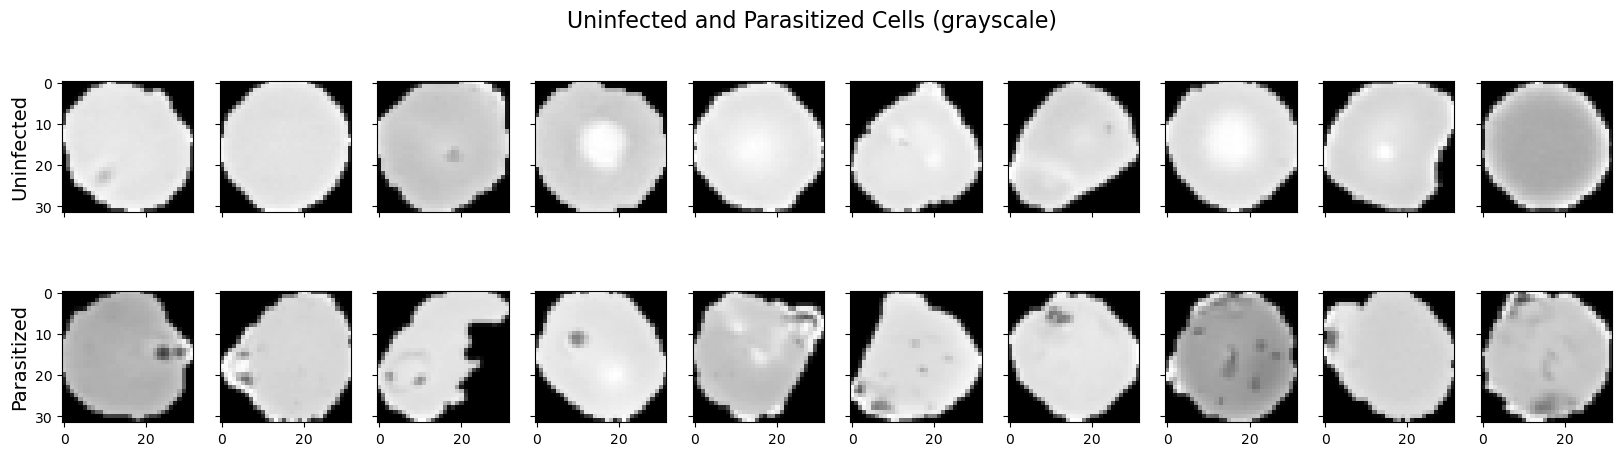

In [9]:
# plot the same images but in grayscale
fig, ax = plt.subplots(2, 10, figsize=(20, 5), sharey=True, sharex=True)
fig.suptitle("Uninfected and Parasitized Cells (grayscale)", fontsize=16)
for i in range(10):
    ax[0, i].imshow(X_bw[uninf_index[i]], cmap="gray")
    ax[1, i].imshow(X_bw[len(uninf_imgs)+para_index[i]], cmap="gray")
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()

> Dataset summary

Inspecting the images we can see that:
- Cells are of different shapes and sizes and that the infected cells have some visible violet spots.
- The morphology of the cells is not uniform and the violet spots are not always in the same place.
- The black borders presents in some images are not relevant and should be removed to avoid noise.
- Due to the fact that the color of the cells is not uniform, the violet spots could be more or less visible depending on the background color of the cell. Maybe the grayscale images will be more useful for the model.
- From the grayscale images we can see that the violet spots are darker than the rest of the cell and that the uninfected cells are lighter. This could be useful for the model, maybe with some preprocessing we can make the darker spots more visible.

We will use the grayscale images in the following steps, but we will keep the RGB images for future use.

> Data Preprocessing

We are going to preprocess the images in order to make them more suitable for the model. We already reduced the size of the images and converted them to grayscale, but we can do more:
1. Remove black borders.
2. Standardize the images by subtracting the mean and dividing by the standard deviation.

In [10]:
def padding(image, size):
    desired_size = size
    old_size = image.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = image.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new('RGB',(desired_size, desired_size))
    new_im.paste(image, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    return new_im

In [46]:
def brighten(image):
    max_ = np.max(image)
    image[image < 0.3] = max_
    return image

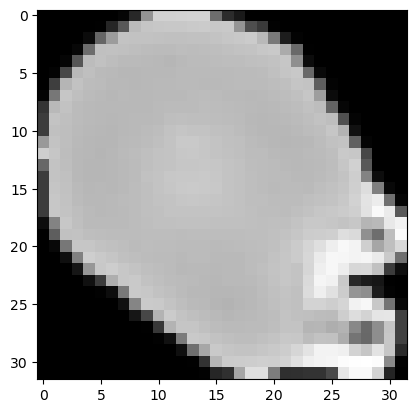

In [49]:
plt.imshow(df_bw.drop(columns=["labels"]).loc[14000].values.reshape(32, 32), cmap="gray")

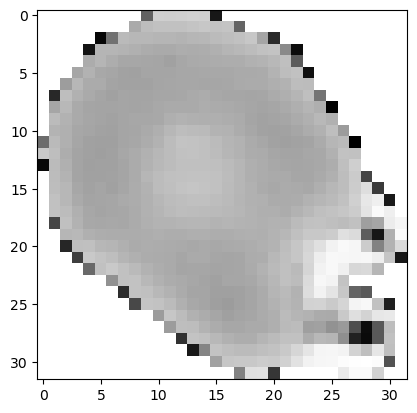

In [47]:
""" Remove black borders from the images """
from skimage import color
img = df_bw.drop(columns=["labels"]).loc[14000]
img =( np.array(img).reshape(32, 32))
#img = color.rgb2gray(img)
img = brighten(img)
plt.imshow(img, cmap='Greys_r')

>Split the dataset into Training and Test sets

- Training set: 70% of the dataset -> we will use this set to train the model after data augmentation
- Test set: 30% of the dataset -> we will use this set to test the model

*During the training phase we will use 5-Fold Cross Validation to evaluate the model and tune its hyperparameters.*

In [9]:
from sklearn.model_selection import train_test_split
# Split the data into training validation and test sets
test_ratio = 0.3
# now make two splits:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df.drop(columns=["labels"]),
    df["labels"],
    test_size=test_ratio,
    random_state=42,
    shuffle=True,
    stratify=y_vert,
)
# and one for the grayscale images
X_train_val_bw, X_test_bw, y_train_val_bw, y_test_bw = train_test_split(
    df_bw.drop(columns=["labels"]),
    df_bw["labels"],
    test_size=test_ratio,
    random_state=42,
    shuffle=True,
    stratify=y_vert,
)

> Understanding model complexity

Using images, our dataset has a lot of features, so we will try to understand if model reduction techniques can help us. We will use PCA to reduce the dimensionality because we have only 2 classes and a supervised model is not necessary.

If the explained variance is not enough to explain the data, we need to use a more complex model. Probably a neural network.

*About LDA: we don't use LDA as a dimensionality reduction method because with just 2 classes the output of the reduction will have only 1 dimension.*

> PCA

In [14]:
"""Utility functions for the PCA analysis"""

from sklearn.decomposition import PCA
import pickle

def explained_variance_ratio(args):
    X, n_components = args
    pca = PCA(n_components=n_components)
    r_pca_df = pd.DataFrame(index=range(X.shape[0]), columns=[str(i) for i in range(n_components)]+['V'])
    g_pca_df = pd.DataFrame(index=range(X.shape[0]), columns=[str(i) for i in range(n_components)]+['V'])
    b_pca_df = pd.DataFrame(index=range(X.shape[0]), columns=[str(i) for i in range(n_components)]+['V'])
    size = int(np.sqrt(X.shape[1]/3))
    for r, x in enumerate(X):
        x = x.reshape(size, size, 3)
        for i in range(3):
            pca.fit(x[:,:,i])
            row = np.append(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())
            if i == 0:
                r_pca_df.loc[r] = row
            elif i == 1:
                g_pca_df.loc[r] = row
            else:
                b_pca_df.loc[r] = row
    pickle.dump(r_pca_df, open('../bin/' + 'r_pca_df_' + str(n_components) + '.pkl', 'wb'))
    pickle.dump(g_pca_df, open('../bin/' + 'g_pca_df_' + str(n_components) + '.pkl', 'wb'))
    pickle.dump(b_pca_df, open('../bin/' + 'b_pca_df_' + str(n_components) + '.pkl', 'wb'))
    print(f'Worker {n_components} done')

def explained_variance_ratio_bw(args):
    X, n_components = args
    pca = PCA(n_components=n_components)
    bw_pca_df = pd.DataFrame(index=range(X.shape[0]), columns=[str(i) for i in range(n_components)]+['V'])
    for r, x in enumerate(X):
        pca.fit(x)
        row = np.append(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())
        bw_pca_df.loc[r] = row
    pickle.dump(bw_pca_df, open('../bin/' + 'bw_pca_df_' + str(n_components) + '.pkl', 'wb'))
    print(f'Worker {n_components} done')

def explained_variance_ratio_flat(args):
    X, n_components = args
    pca = PCA(n_components=n_components)
    pca.fit(X)
    flat_pca_df = pd.DataFrame(columns=[str(i) for i in range(n_components)]+['V'])
    row = np.append(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())
    flat_pca_df.loc[0] = row
    pickle.dump(flat_pca_df, open('../bin/' + 'flat_pca_df_' + str(n_components) + '.pkl', 'wb'))
    print(f'Worker {n_components} done')

In [15]:
"""Commented out because it takes up to 5 minutes to run"""
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    n_components = range(1, 16)
#    arg_list = [(X_train_val.values, n) for n in n_components]
#    executor.map(explained_variance_ratio, arg_list)

Worker 6 done
Worker 5 done
Worker 7 done
Worker 8 done
Worker 3 done
Worker 1 done
Worker 4 done
Worker 2 done
Worker 9 done
Worker 10 done
Worker 11 done
Worker 12 done
Worker 13 done
Worker 14 done
Worker 15 done


In [16]:
"""Commented out because we load the data from the pickle files"""
# Same as above but for black and white images
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    n_components = range(1, 16)
#    arg_list = [(X_train_val_bw.values, n) for n in n_components]
#    executor.map(explained_variance_ratio_bw, arg_list)

In [18]:
"""Same as above but for the flattened images"""
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    n_components = range(1, 32)
#    arg_list = [(X_train_val.values.reshape(X_train_val.shape[0],-1), n) for n in n_components]
#    executor.map(explained_variance_ratio_flat, arg_list)

Worker 1 done
Worker 2 done
Worker 3 done
Worker 4 done
Worker 5 done
Worker 6 done
Worker 7 done
Worker 8 done
Worker 9 done
Worker 10 done
Worker 11 done
Worker 12 done
Worker 13 done
Worker 14 done
Worker 15 done
Worker 16 done
Worker 17 done
Worker 18 done
Worker 19 done
Worker 20 done
Worker 22 done
Worker 21 done
Worker 23 done
Worker 24 done
Worker 25 done
Worker 26 done
Worker 27 done
Worker 28 done
Worker 29 done
Worker 30 done
Worker 31 done


In [19]:
# Load from /bin the pickled dataframes
r_df, g_df, b_df, bw_df, flat_df = [], [], [], [], []
pkl_list = os.listdir('../bin')
pkl_list.sort(key=lambda x: int(x.split('_')[3].split('.')[0]) if x != '.gitignore' else 0)
for pkl in pkl_list:
    if 'r_pca_df' in pkl:
        r_df.append(pickle.load(open('../bin/' + pkl, 'rb')))
    elif 'g_pca_df' in pkl:
        g_df.append(pickle.load(open('../bin/' + pkl, 'rb')))
    elif 'b_pca_df' in pkl:
        b_df.append(pickle.load(open('../bin/' + pkl, 'rb')))
    elif 'bw_pca_df' in pkl:
        bw_df.append(pickle.load(open('../bin/' + pkl, 'rb')))
    elif 'flat_pca_df' in pkl:
        flat_df.append(pickle.load(open('../bin/' + pkl, 'rb')))

Now we plot the total explained variance as a function of the number of components. In this section we will look at RGB channels separately and the grayscale image.

This will help us to understand how many components we need to explain the data and if we can reduce the model complexity. The dashed line represents the baseline explained variance of 95%.

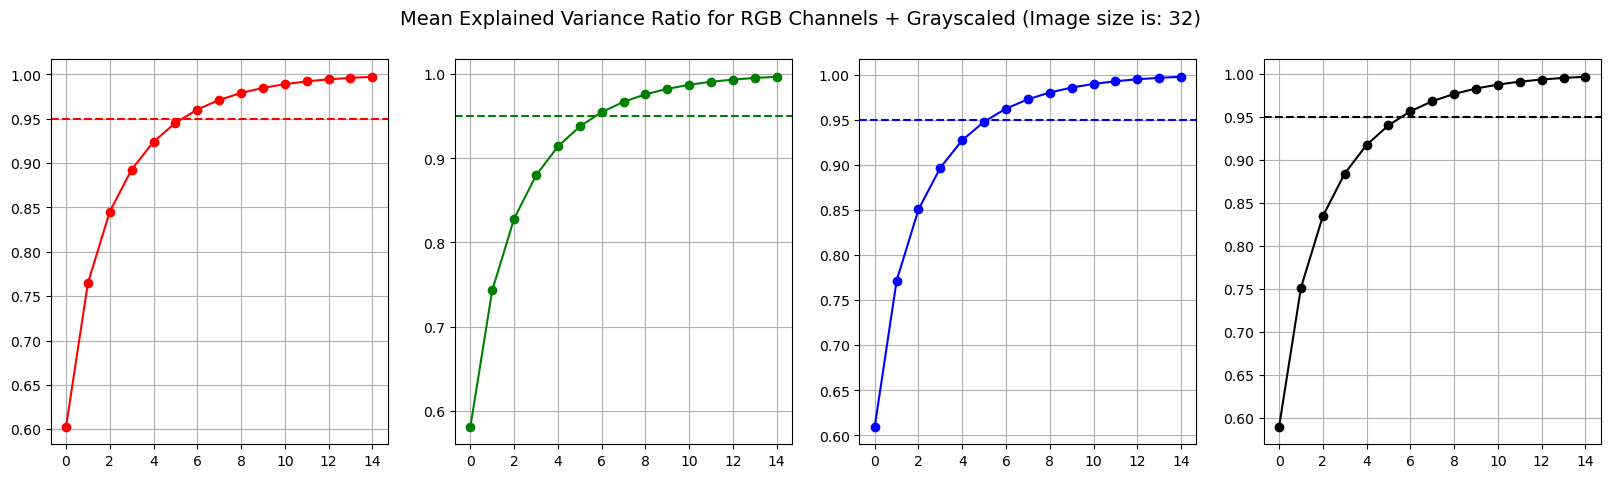

In [20]:
fig = plt.figure(figsize=(20, 5))
plt.suptitle(f'Mean Explained Variance Ratio for RGB Channels + Grayscaled (Image size is: {resize_to})', fontsize=14)
r_mean = [df['V'].mean() for df in r_df]
g_mean = [df['V'].mean() for df in g_df]
b_mean = [df['V'].mean() for df in b_df]
bw_mean = [df['V'].mean() for df in bw_df]
n_components = range(len(r_mean))
fig.add_subplot(1, 4, 1)
plt.plot(n_components, r_mean, 'o-', color='red', scalex=True, scaley=True)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.grid(True)
fig.add_subplot(1, 4, 2)
plt.plot(n_components, g_mean, 'o-', color='green',scalex=True, scaley=True)
plt.axhline(y=0.95, color='g', linestyle='--')
plt.grid(True)
fig.add_subplot(1, 4, 3)
plt.plot(n_components, b_mean, 'o-', color='blue',scalex=True, scaley=True)
plt.axhline(y=0.95, color='b', linestyle='--')
plt.grid(True)
fig.add_subplot(1, 4, 4)
plt.plot(n_components, bw_mean, 'o-', color='black',scalex=True, scaley=True)
plt.axhline(y=0.95, color='black', linestyle='--')
plt.grid(True)

Now we do the same. This time we used the RGB images in the form of a single vector of N x N x 3 features, where N is the number of pixels in each dimension. In this case we are looking at the dataset as observations in a large dimensional space instead of images.

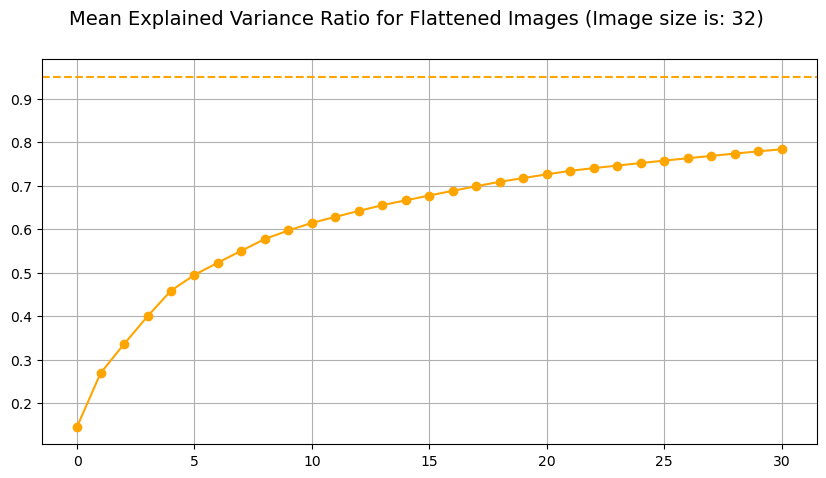

In [21]:
fig = plt.figure(figsize=(10, 5))
plt.suptitle(f'Mean Explained Variance Ratio for Flattened Images (Image size is: {resize_to})', fontsize=14)
flat_var = [df['V'] for df in flat_df]
eigens = range(len(flat_var))
plt.plot(eigens, flat_var, 'o-', color='orange',scalex=True, scaley=True)
plt.axhline(y=0.95, color='orange', linestyle='--')
plt.grid(True)

> Analysis:

Looking at the whole dataset, we can see that the explained variance is not enough to get a precise model after a PCA transformation. This could means that we need a better rappresentation of the data: using images as dataset means that we need to use a model that can handle high dimensional data and that can learn complex relationships between features. We could try to use a larger rappresentation of the images, like a 64x64 pixels image, or we could try to use a neural network and forget about this problem.

If we look at the RGB channels or the grayscale dataset, the explained variance grows very fast and we can see that we can get a good model with a few components. This means that we can reduce the model complexity and we can use a simpler model if we use this rappresentation of the data.

For this reason we will use the grayscale dataset for the rest of the analysis.

> Classification tests

We will use simple models to test the dataset and to understand if we can get a good accuracy with a simple model. Then we will try to optimize the best scoring model searching for the best hyperparameters.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric='euclidean', weights='distance')


In [ ]:
from asyncio.windows_utils import pipe
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import optuna
from keras.preprocessing.image import ImageDataGenerator

# create a function to train and test the model
def classifier(X, y, model, folds):
    # create a K-fold object
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    fitted_model = model
    # create empty lists to store training and prediction the results
    y_true, y_pred = list(), list()
    # loop over the folds, splitting the data into training and testing sets
    for train_index, val_index in skf.split(X, y):
        # split the data into training and testing sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # train the model
        fitted_model.fit(X_train, y_train)
        # evaluate the model on the test set
        y_hat = fitted_model.predict(X_val)
        # store the results
        y_true = np.concatenate((y_true, y_val), axis=0)
        y_pred = np.concatenate((y_pred, y_hat), axis=0)
    # evaluate the accuracy of the model -> todo: add metrics
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy: %.7f" % acc)
    print(f"Confusion Matrix: {confusion_matrix(y_true, y_pred)}")
    return fitted_model

# create a class to optimize the hyperparameters of the model
class classifier_obj:
    def __init__(self, X: np.ndarray, y: np.ndarray, model_name: str):
        # store the data and model
        self.X = X
        self.y = y
        self.model_name = model_name
        self.model = None
        # create a K-fold object
        self.skf = None
        # create empty lists to store training and prediction the results
        self.y_true, self.y_pred = list(), list()
        # Optuna parameters dictionary and trial object
        self.params = {}
    def get_model(self):
        return self.model
    def set_cross_validator(self, folds: int):
        self.skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    def get_cross_validator(self):
        return self.skf
    def objective(self, trial: optuna.trial.Trial, scaler:str, score: str):
        # define the scaler object
        scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
        if scalers == "minmax":
            scaler = MinMaxScaler()
        elif scalers == "standard":
            scaler = StandardScaler()
        else:
            scaler = RobustScaler()
        # istantiate dimensionality reduction object
        dim_red = trial.suggest_categorical("dim_red", ['PCA', None])
        if dim_red == "PCA":
            n_components = trial.suggest_int("n_components", 10, 15)
            dim_red_obj = PCA(n_components=n_components)
        if self.model_name == "KNC":
            n_neighbors = trial.suggest_int("n_neighbors", 1, 19, 2)
            metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
            weights = trial.suggest_categorical("weights", ["uniform", "distance"])
            self.params = {"n_neighbors": n_neighbors, "metric": metric, "weights": weights}
            self.model = KNeighborsClassifier(**self.params)
        
        pipeline = make_pipeline()

> We are making some test with raw hyperparameters

We will use some default hyperparameters and see how the model performs. Then we will try to tune the hyperparameters to improve the model that will score the best on the test set.

da

In [ ]:
model = classifier(
    X_train_val.values, y_train_val.values, KNeighborsClassifier(n_neighbors=5), 5
)
y_pred = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy on test set: %.7f" % accuracy)
print(f"Confusion Matrix: {confusion_matrix(y_test.values, y_pred)}")

We can see that this model is not performing well: using the default hyperparameters we get an accuracy of 60% on the validation and the test set. This means that we are near to the baseline accuracy of 50% (random guessing).

Let's see how the other models perform.

In [ ]:
# Random Forest
model = classifier(
    X_train_val.values,
    y_train_val.values,
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    5,
)
y_pred = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy on test set: %.7f" % accuracy)
print(f"Confusion Matrix: {confusion_matrix(y_test.values, y_pred)}")

In [ ]:
# Support Vetor Machine - Linear
# TODO: - make SGDClassifier with Kernel Approximation Nyström
model = classifier(
    X=X_train_val.values,
    y=y_train_val.values,
    model=LinearSVC(
       C=1.0e-3, max_iter=10000, class_weight="balanced", random_state=42, tol=1e-5
    ),
    folds=5,
)
y_pred = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy on test set: %.7f" % accuracy)
print(f"Confusion Matrix: {confusion_matrix(y_test.values, y_pred)}")

In [ ]:
study = optuna.create_study(direction="maximize", study_name="Image_Analysis")

In [ ]:
func = lambda trial: objective_KNC(
    trial, X_train_val, y_train_val.values.ravel(), KNeighborsClassifier, "KNC"
)
# study.optimize(func, n_trials=100)

> Perform data augmentation

To improve the model performance, we will perform data augmentation on the training set. We will use the following transformations:
- Rotation
- Zoom
- Horizontal and Vertical Flips
- Width and Height Shifts
- Shear Transformation
- Brightness
- Contrast
- Gaussian Noise
- Gaussian Blur
- Motion Blur
- Median Blur
- Random Crop
- To Gray
- Coarse Dropout
- Invert

In [ ]:
# we will use the Keras ImageDataGenerator to augment the data
from keras.preprocessing.image import ImageDataGenerator

# create an instance of the ImageDataGenerator
datagen = ImageDataGenerator()
# fit the generator to the data - this will calculate the mean and std of the data
datagen.fit(X_train)
# get a batch iterator to efficiently iterate over the training data
train_iterator = datagen.flow(X_train, y_train, batch_size=32)
# get a batch iterator for the validation data
val_iterator = datagen.flow(X_val, y_val, batch_size=32)
# fit the model
mod

> [Histograms of Oriented Gradients (HOG)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)

is a feature extraction technique used in image analysis to identify and recognize objects in an image. The HOG technique describes the local appearance of an image in terms of the distribution of the intensity gradients' orientations.

We will use the HOG technique to extract features from the images and use them as input for the model and see if we can get better results.


In [ ]:
def split_plot(
    x: np.ndarray, index: int, label: str, plot: bool
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split image into RGB channels and plot them"""
    # convert vector into image to be splittable
    r, g, b = Image.Image.split(vec2img(x[index]))
    # treat each channel as a numpy array. No need to multiply values by 255 and cast to uint8
    # because the image is already in uint8 format
    npr = np.asarray(r)
    npg = np.asarray(g)
    npb = np.asarray(b)
    np_img = (npr, npg, npb, x[index])
    if plot:
        [_, ax] = plt.subplots(1, 4, figsize=(5, 5), dpi=100)
        cmaps = ["Reds", "Greens", "Blues"]
        channels = ["Red", "Green", "Blue", "RGB"]
        for _ in range(4):
            ax[_].set_title(f"{label[0]} {channels[_]}")
            if _ < 3:
                ax[_].imshow(np_img[_], cmap=cmaps[_])
            else:
                ax[_].imshow(np_img[_])
            ax[_].axis("off")
    return np_img

Create a function to normalize the images and convert them to numpy arrays.
We want to center the data around the mean and scale it to unit variance. This is done by subtracting the mean and dividing by the standard deviation.

In [ ]:
def normalize_by_channel(X: np.ndarray) -> np.ndarray:
    """Center and scale the data to have zero mean and unit variance.
    The result is obtained by subtracting the mean and dividing by the standard deviation.
    We do this for each channel of the image, then we merge the channels back together.
    Args:
        X (np.ndarray): Matrix of features to be normalized

    Returns:
        np.ndarray: Matrix of normalized features
    """
    # initialize the list of normalized images
    norm_imgs = []
    # loop over each row in X
    for entry in X:
        # convert the vector to an image and split it into RGB channels
        r, g, b = Image.Image.split(vec2img(entry))
        # convert the channels to numpy arrays to perform the normalization
        npr = np.asarray(r).astype(np.uint8)
        npg = np.asarray(g).astype(np.uint8)
        npb = np.asarray(b).astype(np.uint8)
        # find the mean and standard deviation of each channel
        r_norm = (npr - np.mean(npr)) / np.std(npr)

> Construct the dataset matrices X and y

> Visualize some data informations

> Extract features from images with PCA analysis

> Define generical wrapper function to be able to change models